In [1]:
import os
import sys
sys.path.append('utils')
from dataset.spot import DailyDataset, get_loader, TOTAL_STD, TOTAL_MEAN, SPOT
from tool import to_gpu
import torch
import torch.nn as nn
from tqdm import trange, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import types

%matplotlib inline

In [2]:
# from forecast_model import RNN as Model
# from forecast_model import LSTM as Model
from forecast_model import GRU as Model

In [3]:
def mae(pred, y_true, mode='default'):
    if mode == 'max':
        out = np.abs(pred.reshape(-1, 24).max(axis=-1) - y_true.reshape(-1, 24).max(axis=-1)).mean()
    elif mode == 'min':
        out = np.abs(pred.reshape(-1, 24).min(axis=-1) - y_true.reshape(-1, 24).min(axis=-1)).mean()
    else:
        out = np.abs(pred - y_true).mean()
    return out

def rmse(pred, y_true):
    out = np.power((pred - y_true), 2).mean()
    return math.sqrt(out)

def mape(pred, y_true, threshold=1e-2):
    pred.reshape(y_true.shape)
    f = lambda o,c: (math.fabs((o-c) / float(o)))*1.0 if math.fabs(o) > threshold else np.nan
    f = np.vectorize(f)
    error = f(y_true, pred)    
    errorCnts = error.shape[0]-np.sum(np.isnan(error),axis=0)
    error = np.nan_to_num(error)
    return np.sum(error, axis=0) / errorCnts

In [4]:
dataset = DailyDataset(N=1600, W=14, seasonal=0)
loader = get_loader(dataset, batch_size=64, shuffle=True, num_workers=2)

Data build range: [window(2011-08-01 00:00:00) - 2011-08-15 00:00:00, 2015-12-31 00:00:00]


In [5]:
trainX, trainY = dataset.get_io('2012-01-01', '2015-12-31')
testX, testY = dataset.get_io('2012-01-01', '2016-06-30')
with torch.no_grad():
    test_period_input = to_gpu(testX)

In [6]:
PATH = './runs/forecast/'
################################## RNN
# run = 'rnn'
# model = to_gpu(Model(input_dim=24, hidden_size=64, output_dim=24))
# model.load_state_dict(torch.load(os.path.join(PATH, run, 'snapshots16.pth')))
################################## LSTM
# run = 'lstm'
# model = to_gpu(Model(input_dim=24, hidden_size=64, output_dim=24))
# model.load_state_dict(torch.load(os.path.join(PATH, run, 'snapshots13.pth')))
################################### GRU
run = 'gru'
model = to_gpu(Model(input_dim=24, hidden_size=64, output_dim=24))
model.load_state_dict(torch.load(os.path.join(PATH, run, 'snapshots21.pth')))

In [7]:
output, hidden = model.forecast(test_period_input)
test_period_forecast = output.cpu().detach().numpy()*TOTAL_STD + TOTAL_MEAN

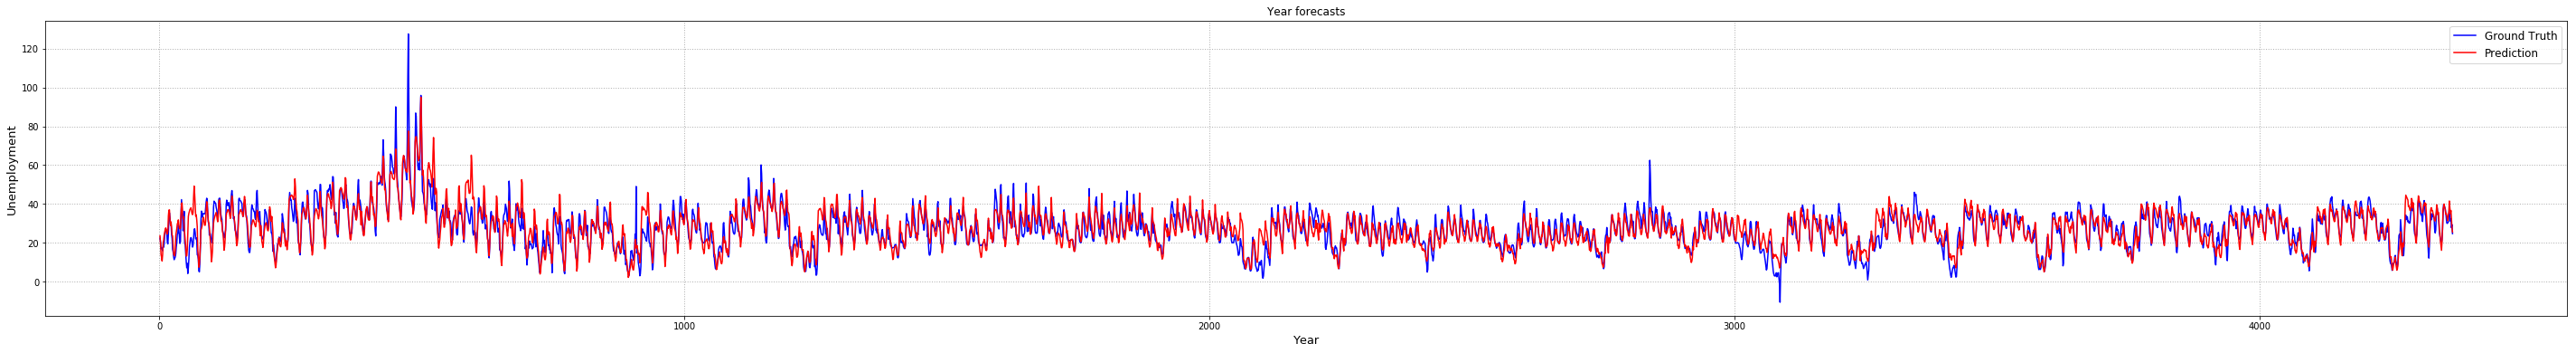

In [24]:
y_pred = test_period_forecast[-182:].reshape((182*24,))
y = torch.reshape(testY[-182:,:],(182*24,)).numpy() * TOTAL_STD + TOTAL_MEAN
x=np.linspace(1, 182*24, 182*24)
plt.figure(figsize=(50,6))
plt.plot(x, y[-182*24:], color='blue', label='Ground Truth')
plt.plot(x, y_pred[-182*24:], color='red', label='Prediction')

# plt.xticks(x)
# plt.xlim(0,23)
plt.legend(fontsize='large') # 显示图例

plt.title('Year forecasts')
plt.xlabel('Year',fontsize=13)
plt.ylabel('Unemployment',fontsize=13)

plt.grid(linestyle=':', linewidth=1)

plt.show()

In [18]:
d={'ground_truth':y,'prediction':y_pred}
indexs = pd.date_range('2016-01-01 00:30:00', periods=182*24, freq='H')
df=pd.DataFrame(d,index=indexs)

In [19]:
def plot_results(df, target_field, rename_field=None):
    _, zip_axes = plt.subplots(3,2,figsize=(14,5*3))
    axes = [zip_axes[i][j] for i in range(3) for j in range(2)]

    selected_results = pd.DataFrame()
    selected_results['Ground Truth'] = df['ground_truth']
    if rename_field is None:
        rename_field = target_field
    selected_results[rename_field] = df[target_field]

    for i,m in enumerate(['Jan','Feb','Mar','Apr','May','Jun']):
        selected = selected_results.loc['2016-0%s'%(i+1):'2016-0%s'%(i+1)]
        mae = (selected['Ground Truth'] - selected[rename_field]).abs().mean()
        rmse = np.sqrt(((selected['Ground Truth'] - selected[rename_field])**2).mean())
        selected.plot(ax=axes[i],style=['blue','red'], use_index=False)
        axes[i].set_xlim(0, selected.shape[0])
        axes[i].set_xlabel("%s (RMSE: %.2f, MAE: %.2f)" % (m, rmse, mae),fontsize=13)
        axes[i].set_ylabel('Price (€/MWh)',fontsize=13)
        axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
        axes[i].legend(loc=0,prop={'size':11})
        axes[i].grid()
        
    axes[1].set_ylim(-10, 70)
    axes[2].set_ylim(-5, 60)
    axes[4].set_ylim(-15, 60)
    axes[5].set_ylim(0, 60)

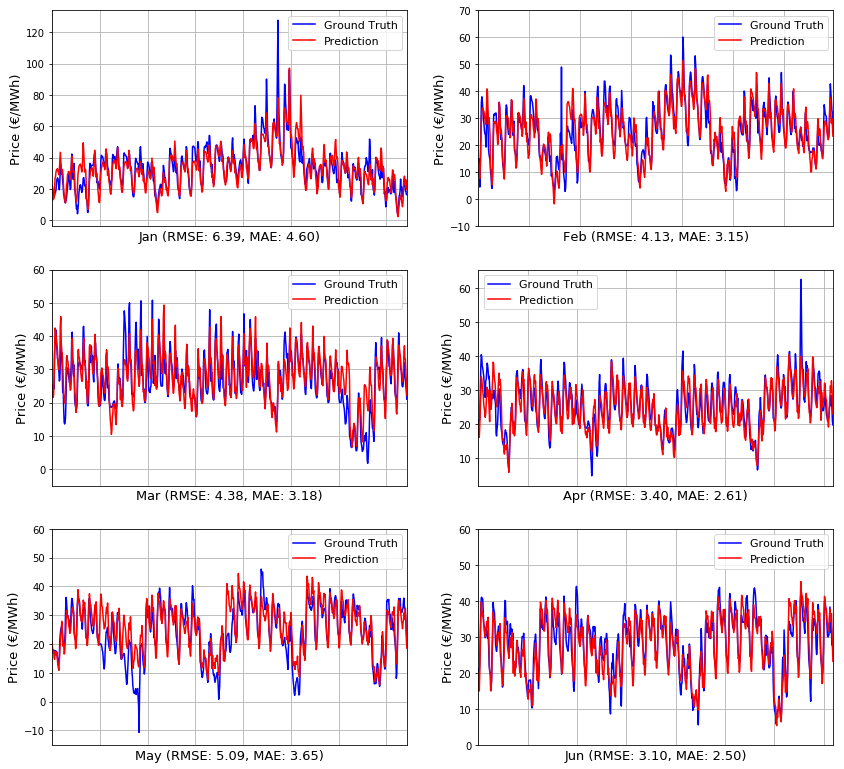

In [11]:
plot_results(df, target_field='prediction', rename_field='Prediction')
# plt.savefig('./figures/gru-s.jpg',bbox_inches='tight')

In [10]:
h_ = torch.stack(hidden, 1).squeeze(2)[0].mean(dim=1).cpu().data.numpy()
var_ = torch.stack(hidden, 1).squeeze(2)[0].std(dim=1).cpu().data.numpy()

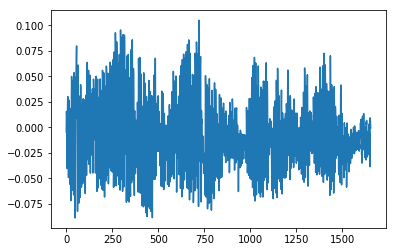

In [11]:
plt.plot(h_)

In [27]:
# np.savetxt('./h_.csv', h_, delimiter = ',')  

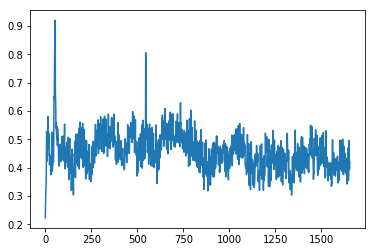

In [12]:
plt.plot(var_)

In [13]:
np.savetxt('./var_.csv', var_, delimiter = ',')  

# start rolling

In [12]:
outputs = []
output, h = model.forecast(to_gpu(testY[-1].unsqueeze(0)), hidden[-1])
outputs += [output]
for _ in trange(61):
    output, h = model.forecast(output, h[-1])
    outputs += [output]

100%|██████████| 61/61 [00:00<00:00, 2512.15it/s]


In [13]:
# outputs

In [14]:
roll_output = torch.stack(outputs, 1).squeeze(2)[0]

In [15]:
roll_output.shape

torch.Size([62, 24])

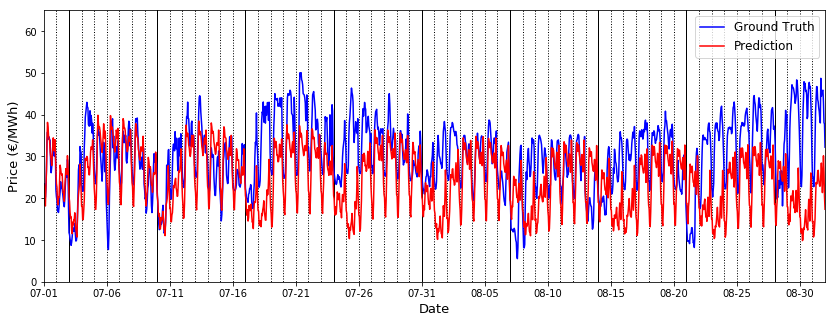

In [16]:
y_true = SPOT["2016-07-01":"2016-08-31"].values
y_pred = torch.reshape(roll_output.cpu(),(62*24,)).detach().numpy() * TOTAL_STD + TOTAL_MEAN
x=np.linspace(1, 62*24, 62*24)
plt.figure(figsize=(14,5))
plt.plot(x, y_true, color='blue', label='Ground Truth')
plt.plot(x, y_pred, color='red', label='Prediction')
plt.legend(fontsize='large') # 显示图例

plt.xlim(0,62*24)
plt.ylim(0,65)
plt.vlines(np.array(range(1, 62, 1))*24, ymax=100, ymin=-10, linestyle=':', linewidth=1)
plt.vlines(np.array(range(2, 62, 7))*24, ymax=100, ymin=-10, linestyle='-', linewidth=1)
plt.xticks(np.array(range(0, 62, 5))*24, 
           ['07-01','07-06','07-11','07-16','07-21', '07-26', '07-31', '08-05','08-10','08-15','08-20','08-25','08-30'])

plt.xlabel('Date',fontsize=13)
plt.ylabel('Price (€/MWh)',fontsize=13)

# plt.savefig('./figures/roll_gru.jpg',bbox_inches='tight')

plt.show()

In [17]:
y_true = SPOT["2016-07-01":"2016-08-31"].values
mae(y_pred, y_true), rmse(y_pred, y_true), mape(y_pred, y_true)

(7.727676475740247, 9.933131053283155, 0.266917820333837)

In [18]:
# RNN (21.098268515627872, 23.138350995271544, 0.7664101662884072)
# LSTM (7.079228096162119, 9.343430222819606, 0.28631295250277705)
# GRU (9.726836888918312, 11.514630990666275, 0.32014963001986096)

In [19]:
mae(y_pred[:14*24], y_true[:14*24]), rmse(y_pred[:14*24], y_true[:14*24]), mape(y_pred[:14*24], y_true[:14*24])

(3.965613303626308, 5.011828993036553, 0.1601035260325886)

In [20]:
# RNN (12.891089191436768, 15.007101730061635, 0.516226543825921)
# LSTM (3.4570974225089666, 4.343699529311953, 0.15100612010035577)